# Text Classification - Deep Learning Sequential Models - LSTMs


Another new and interesting approach to supervised deep learning is the use
of recurrent neural networks (RNNs) and long short-term memory networks (LSTMs)
which also considers the sequence of data (words, events and so on). These are more
advanced models than your regular fully connected deep networks and usually take
more time to train.

![](https://i.imgur.com/c8qGKX8.png)


In [1]:
!nvidia-smi

Wed Jun 15 11:15:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 7.3 MB/s 
     |████████████████████████████████| 287 kB 52.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [4]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

In [7]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [8]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:06<00:00, 2237.74it/s]

CPU times: user 29 s, sys: 229 ms, total: 29.2 s
Wall time: 35 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [9]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [10]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
t.word_index['<UNK>']

1

In [11]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [12]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175813
Number of Documents=35000


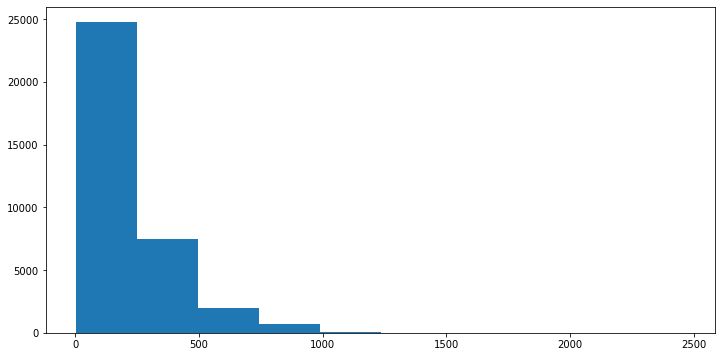

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
h1 = ax.hist(train_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [14]:
MAX_SEQUENCE_LENGTH = 1000

In [15]:
# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [17]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [18]:
VOCAB_SIZE = len(t.word_index)

# LSTM Model

# Build Model Architecture


# Embeddings

The Embedding layer helps us generate the word embeddings from scratch. This layer
is also initialized with some weights and is updated based on our optimizer, similar to
weights on the neuron units in other layers when the network tries to minimize the loss
in each epoch. Thus, the embedding layer tries to optimize its weights such that we get
the best word embeddings that will generate minimum error in the model and capture
semantic similarity and relationships among words. How do we get the embeddings?
Let’s say we have a review with three terms ['movie', 'was', 'good'] and a vocab_map
consisting of word to index mappings for 175860 words. 

![](https://i.imgur.com/wOPsWof.png)


# LSTM

LSTMs try to overcome
the shortcomings of RNN models, especially with regard to handling long-term
dependencies and problems that occur when the weight matrix associated with the
units (neurons) become too small (leading to vanishing gradient) or too large (leading to
exploding gradient). These architectures are more complex than regular deep networks
and going into detailed internals and math concepts are out of the current scope, but we
will try to cover the essentials here without making it math heavy

![](https://i.imgur.com/c8qGKX8.png)

The sequence of operations in the LSTM cell is briefly shown as follows.

![](https://i.imgur.com/uiIbDk1.png)

In [19]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token i.e word embedding size
LSTM_DIM = 128 # the number of hidden units in each LSTM cell i.e the hidden state embedding size; 
# total LSTM cells = sequence length (num of tokens) i.e total number of words per document

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                    output_dim=EMBEDDING_DIM, 
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         52743900  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 52,996,829
Trainable params: 52,996,829
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [20]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 35s 116ms/step - loss: 0.4230 - accuracy: 0.7967 - val_loss: 0.4055 - val_accuracy: 0.8274
Epoch 2/10
247/247 [==============================] - 28s 113ms/step - loss: 0.1832 - accuracy: 0.9318 - val_loss: 0.3268 - val_accuracy: 0.8726
Epoch 3/10
247/247 [==============================] - 28s 112ms/step - loss: 0.0959 - accuracy: 0.9683 - val_loss: 0.3675 - val_accuracy: 0.8714
Epoch 4/10
247/247 [==============================] - 28s 112ms/step - loss: 0.0408 - accuracy: 0.9861 - val_loss: 0.4707 - val_accuracy: 0.8671
Epoch 4: early stopping


## Evaluate Model Performance

In [21]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 9s 20ms/step - loss: 0.3405 - accuracy: 0.8610
Accuracy: 86.10%


In [22]:
predict_probas = model.predict(X_test)
predict_probas = predict_probas.ravel()

In [23]:
predictions = [1 if proba > 0.5 else 0 for proba in predict_probas]
predictions[:10]

[0, 1, 0, 1, 1, 0, 1, 0, 1, 1]

In [24]:
predictions = le.inverse_transform(predictions)
predictions[:10]

array(['negative', 'positive', 'negative', 'positive', 'positive',
       'negative', 'positive', 'negative', 'positive', 'positive'],
      dtype=object)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.82      0.92      0.87      7490
    positive       0.91      0.80      0.85      7510

    accuracy                           0.86     15000
   macro avg       0.87      0.86      0.86     15000
weighted avg       0.87      0.86      0.86     15000



,negative,positive
negative,6885,605
positive,1480,6030


# Stacked LSTM Model

![](https://i.imgur.com/IVzTuBK.png)

## Build Model Architecture

In [26]:
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                     output_dim=EMBEDDING_DIM, 
                                     input_length=MAX_SEQUENCE_LENGTH))


model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         52743900  
                                                                 
 lstm_1 (LSTM)               (None, 1000, 128)         219648    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 53,128,413
Trainable params: 53,128,413
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [27]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
           callbacks=[es],
           shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 50s 190ms/step - loss: 0.4060 - accuracy: 0.8131 - val_loss: 0.3181 - val_accuracy: 0.8737
Epoch 2/10
247/247 [==============================] - 46s 187ms/step - loss: 0.1609 - accuracy: 0.9427 - val_loss: 0.3700 - val_accuracy: 0.8731
Epoch 3/10
247/247 [==============================] - 46s 187ms/step - loss: 0.0722 - accuracy: 0.9762 - val_loss: 0.4588 - val_accuracy: 0.8557
Epoch 3: early stopping


## Evaluate Model Performance

In [28]:
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 17s 37ms/step - loss: 0.3103 - accuracy: 0.8788
Accuracy: 87.88%


In [29]:
predict_probas = model2.predict(X_test)
predict_probas = predict_probas.ravel()
predictions = [1 if proba > 0.5 else 0 for proba in predict_probas]

In [30]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive']

In [31]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      7490
    positive       0.90      0.85      0.88      7510

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,negative,positive
negative,6783,707
positive,1111,6399
